# IEMOCAP

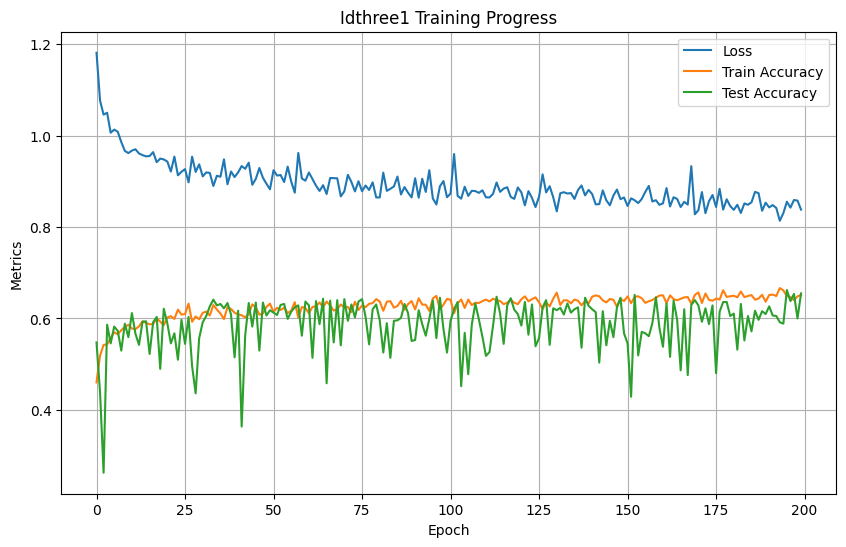

Best Acc = 0.6621052631578948, at epoch 196


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import os
from IPython.display import Audio
# Load the metrics
name = 'Idthree1'

class Wav2Vec2ClassificationHead(nn.Module):
    """Head for wav2vec downstream task."""

    def __init__(self, dense_size, dropout_rate, num_labels):
        super().__init__()
        self.dense = nn.Linear(dense_size, dense_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.out_proj = nn.Linear(dense_size, num_labels)

    def forward(self, features):
        features = torch.mean(features, dim=-1)
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


# checkpoint = torch.load('/home/felix/Aopp/mm/E_{}.pth'.format(name))
folder_path = '/home/felix/Aopp/mm/{}'.format(name)

checkpoint = torch.load(os.path.join(folder_path, 'last.pth'))


# losses = checkpoint.get('losses', 1)[:300]
# train_accs = checkpoint.get('train_accs', 1)[:300]
# test_accs = checkpoint.get('test_accs', 1)[:300]
losses = checkpoint.get('losses', 1)
train_accs = checkpoint.get('train_accs', 1)
test_accs = checkpoint.get('test_accs', 1)

# # Plotting
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Loss')
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()
plt.title('{} Training Progress'.format(name))
plt.grid(True)
plt.show()
# plt.sbavefig('training_progress.png')  # Save the plot as a file

checkpoint = torch.load(os.path.join(folder_path, 'best.pth'))
best_test_acc = checkpoint.get('best_test_acc', 0)
epoch = checkpoint.get('epoch', 1)

print("Best Acc = {}, at epoch {}".format(best_test_acc, epoch))

F1 score: 0.655932023521144
              precision    recall  f1-score   support

     Excited       0.68      0.61      0.64       898
       Anger       0.82      0.63      0.71       874
         Sad       0.91      0.43      0.58       890
     Neutral       0.56      0.88      0.69      1324

    accuracy                           0.67      3986
   macro avg       0.74      0.64      0.66      3986
weighted avg       0.72      0.67      0.66      3986



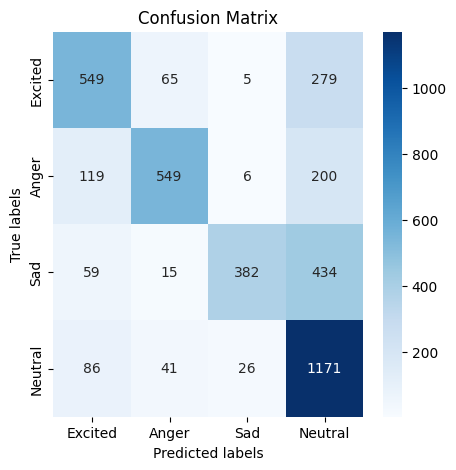

In [3]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
import pandas as pd
import torchaudio
import torch

from torch.nn.utils.rnn import pad_sequence
from torch.utils import data
from d2l import torch as d2l



# 加载最优模型
checkpoint = torch.load(os.path.join(folder_path, 'best.pth'))
net = checkpoint['model']

label_list = ['Excited','Anger','Sad','Neutral']  # 情绪类别列表

# 初始化预测和真实标签列表
all_preds = []
all_labels = []

# 切换到评估模式
net.eval()
front_path = '/home/felix/Aopp/0.0/IEMOCAP/iemocap/IEMOCAP_full_release'
test_path = "/home/felix/Aopp/FINAL/data/IEMOCAP/lablefusing3/test{}/train.csv".format(name[-1])

class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
   
    def __len__(self):
        return len(self.data)
   
    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]
        return sample, target
    
def speech_file_to_array_fn(path):
    ## add path hear

    speech_array, sampling_rate = torchaudio.load(os.path.join(front_path, path))
    resampler = torchaudio.transforms.Resample(sampling_rate, 16000)
    speech = resampler(speech_array).squeeze().numpy()
    return torch.tensor(speech)

def label_to_id(label, label_list):
    if len(label_list) > 0:
        return label_list.index(label) if label in label_list else -1
    return label

def load_dataset_csv(path, label_list):
    temp_df = pd.read_csv(path, sep="\t", encoding="utf-8")


    speech_list = [speech_file_to_array_fn(file_path) for file_path in temp_df['path']]
    target_list = [label_to_id(label, label_list) for label in temp_df['emotion']]

    return MyDataset(speech_list,target_list)

def get_dataloader_workers():
    return 16

def collate_fn(batch):
    # Assume that each element in "batch" is a tuple (data, label)
    data = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    # Pad sequences in this batch
    data = pad_sequence(data, batch_first=True)

    return data, torch.tensor(labels)



test_iter = data.DataLoader(load_dataset_csv(test_path, label_list), 16, shuffle=True,
                             num_workers=get_dataloader_workers(), collate_fn=collate_fn)



device = d2l.try_gpu()
# 迭代验证集，进行预测
for X, labels in test_iter:
    X, labels = X.to(device), labels.to(device)

    # 计算预测结果
    outputs = net(X)
    _, preds = outputs.max(1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# 计算混淆矩阵
cf_matrix = confusion_matrix(all_labels, all_preds)

# 计算F1分数
f1 = f1_score(all_labels, all_preds, average='macro')
print('F1 score:', f1)

# 打印分类报告
print(classification_report(all_labels, all_preds, target_names=label_list))

# 绘制混淆矩阵的热力图
plt.figure(figsize=(5,5))
sns.heatmap(cf_matrix, annot=True, fmt='d',cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [4]:
def find_data_label(to_check, test_iter):
    batch_num = to_check // 16
    sequence_num = to_check % 16
    i = 0
    for X, labels in test_iter:
        if i == batch_num:
            return X[sequence_num], labels[sequence_num]
        i = i + 1

In [11]:
to_check_num = 329
audio_file, ground_true = find_data_label(to_check_num, test_iter)

# print("Ground True:",label_list[ground_true])
print("Ground True:",label_list[all_labels[to_check_num]])
print("Prediction :",label_list[all_preds[to_check_num]])
Audio(audio_file, rate= 16000)

Ground True: Anger
Prediction : Anger


In [ ]:
import pickle

with open(os.path.join(folder_path, 'all_labels.pkl'), 'wb') as f:
    pickle.dump(all_labels, f)
with open(os.path.join(folder_path, 'all_preds.pkl'), 'wb') as f:
    pickle.dump(all_preds, f)


# IEMOCAP ALL

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import pickle

label_list= ['Excited','Anger','Sad','Neutral']
folder_list = ["1", "2", "3", "4", "5"]
frontt_path = '/home/felix/Aopp/mm/Idthree'

all_all_labels = []
all_all_preds = []
for folder in folder_list:
    folder = frontt_path + folder
    with open(f"{folder}/all_labels.pkl", "rb") as f:
        all_labels = pickle.load(f)
    with open(f"{folder}/all_preds.pkl", "rb") as f:
        all_preds = pickle.load(f)

    all_all_labels+=all_labels
    all_all_preds+=all_preds
    # 计算混淆矩阵
cf_matrix = confusion_matrix(all_all_labels, all_all_preds)

# 计算F1分数
f1 = f1_score(all_all_labels, all_all_preds, average='macro')
print(f'All F1 score:', f1)

# 打印分类报告
print(classification_report(all_all_labels, all_all_preds, target_names=label_list))

# 绘制混淆矩阵的热力图
plt.figure(figsize=(5,5))
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix for All')
plt.show()
    

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import pickle
label_list= ['Excited','Anger','Sad','Neutral']
folder_list = ["1", "2", "3", "4", "5"]
frontt_path = '/home/felix/Aopp/mm/Idthree'
index_list = ["accuracy", "macro avg F1 Score", "weighted avg F1 Score"] 
df = pd.DataFrame(index=index_list, columns=folder_list) 
for folder in folder_list:
    path = frontt_path + folder
    with open(f"{path}/all_labels.pkl", "rb") as f:
        all_labels = pickle.load(f)
    with open(f"{path}/all_preds.pkl", "rb") as f:
        all_preds = pickle.load(f)

    # # 计算混淆矩阵
    # cf_matrix = confusion_matrix(all_labels, all_preds)

    # # 计算F1分数
    # f1 = f1_score(all_labels, all_preds, average='macro')
    # print(f'Folder: {folder}, F1 score:', f1)

    # # 打印分类报告
    # print(classification_report(all_labels, all_preds, target_names=label_list))

    # # 绘制混淆矩阵的热力图
    # plt.figure(figsize=(5,5))
    # sns.heatmap(cf_matrix, annot=True, cmap='Blues', xticklabels=label_list, yticklabels=label_list)
    # plt.xlabel('Predicted labels')
    # plt.ylabel('True labels')
    # plt.title(f'Confusion Matrix for folder {folder}')
    # plt.show()

        # 计算accuracy
    acc = accuracy_score(all_labels, all_preds)
    df.loc["accuracy", folder] = acc

    # 计算macro avg F1 Score
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    df.loc["macro avg F1 Score", folder] = macro_f1

    # 计算weighted avg F1 Score
    weighted_f1 = f1_score(all_labels, all_preds,   average='weighted')
    df.loc["weighted avg F1 Score", folder] = weighted_f1
df







# import pandas as pd
# from sklearn.metrics import accuracy_score

# folder_list = ["03", "08", "09", "10", "11", "12", "13", "14", "15", "16"]
# index_list = ["accuracy", "macro avg F1 Score", "weighted avg F1 Score"] 
# df = pd.DataFrame(index=index_list, columns=folder_list) 

# for folder in folder_list:
#     with open(f"{folder}/all_labels.pkl", "rb") as f:
#         all_labels = pickle.load(f)
#     with open(f"{folder}/all_preds.pkl", "rb") as f:
#         all_preds = pickle.load(f)

#     # 计算accuracy
#     acc = accuracy_score(all_labels, all_preds)
#     df.loc["accuracy", folder] = acc

#     # 计算macro avg F1 Score
#     macro_f1 = f1_score(all_labels, all_preds, average='macro')
#     df.loc["macro avg F1 Score", folder] = macro_f1

#     # 计算weighted avg F1 Score
#     weighted_f1 = f1_score(all_labels, all_preds,   average='weighted')
#     df.loc["weighted avg F1 Score", folder] = weighted_f1

# # 输出表格
# print(df)

# EmoDB

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import os
# Load the metrics
name = 'E16'

class Wav2Vec2ClassificationHead(nn.Module):
    """Head for wav2vec downstream task."""

    def __init__(self, dense_size, dropout_rate, num_labels):
        super().__init__()
        self.dense = nn.Linear(dense_size, dense_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.out_proj = nn.Linear(dense_size, num_labels)

    def forward(self, features):
        features = torch.mean(features, dim=-1)
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


# checkpoint = torch.load('/home/felix/Aopp/mm/E_{}.pth'.format(name))
folder_path = '/home/felix/Aopp/mm/{}'.format(name)

checkpoint = torch.load(os.path.join(folder_path, 'last.pth'))


# losses = checkpoint.get('losses', 1)[:300]
# train_accs = checkpoint.get('train_accs', 1)[:300]
# test_accs = checkpoint.get('test_accs', 1)[:300]
losses = checkpoint.get('losses', 1)
train_accs = checkpoint.get('train_accs', 1)
test_accs = checkpoint.get('test_accs', 1)

# # Plotting
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Loss')
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()
plt.title('{} Training Progress'.format(name))
plt.grid(True)
plt.show()
# plt.sbavefig('training_progress.png')  # Save the plot as a file

checkpoint = torch.load(os.path.join(folder_path, 'best.pth'))
best_test_acc = checkpoint.get('best_test_acc', 0)
epoch = checkpoint.get('epoch', 1)

print("Best Acc = {}, at epoch {}".format(best_test_acc, epoch))

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
import pandas as pd
import torchaudio
import torch

from torch.nn.utils.rnn import pad_sequence
from torch.utils import data
from d2l import torch as d2l



# 加载最优模型
checkpoint = torch.load(os.path.join(folder_path, 'best.pth'))
net = checkpoint['model']

label_list = ['P','NH','NL','Ne']  # 情绪类别列表

# 初始化预测和真实标签列表
all_preds = []
all_labels = []

# 切换到评估模式
net.eval()

test_path = "/home/felix/Aopp/FINAL/data/EmoDB/{}/test.csv".format(name[1:])
# test_path = "/home/felix/Aopp/FINAL/data/EmoDB/14/test.csv"

class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
   
    def __len__(self):
        return len(self.data)
   
    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]
        return sample, target
    
def speech_file_to_array_fn(path):
    speech_array, sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(sampling_rate, 16000)
    speech = resampler(speech_array).squeeze().numpy()
    return torch.tensor(speech)

def label_to_id(label, label_list):
    if len(label_list) > 0:
        return label_list.index(label) if label in label_list else -1
    return label

def load_dataset_csv(path, label_list):
    temp_df = pd.read_csv(path, sep="\t", encoding="utf-8" )
    
    speech_list = [speech_file_to_array_fn(path) for path in temp_df['path']]
    target_list = [label_to_id(label, label_list) for label in temp_df['emotion']]

    return MyDataset(speech_list,target_list)

def get_dataloader_workers():
    return 4

def collate_fn(batch):
    # Assume that each element in "batch" is a tuple (data, label)
    data = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    # Pad sequences in this batch
    data = pad_sequence(data, batch_first=True)

    return data, torch.tensor(labels)



test_iter = data.DataLoader(load_dataset_csv(test_path, label_list), 64, shuffle=True,
                             num_workers=get_dataloader_workers(), collate_fn=collate_fn)



device = d2l.try_gpu()
# 迭代验证集，进行预测
for X, labels in test_iter:
    X, labels = X.to(device), labels.to(device)

    # 计算预测结果
    outputs = net(X)
    _, preds = outputs.max(1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# 计算混淆矩阵
cf_matrix = confusion_matrix(all_labels, all_preds)

# 计算F1分数
f1 = f1_score(all_labels, all_preds, average='macro')
print('F1 score:', f1)

# 打印分类报告
print(classification_report(all_labels, all_preds, target_names=label_list))

# 绘制混淆矩阵的热力图
plt.figure(figsize=(5,5))
sns.heatmap(cf_matrix, annot=True, cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import pickle

with open(os.path.join(folder_path, 'all_labels.pkl'), 'wb') as f:
    pickle.dump(all_labels, f)
with open(os.path.join(folder_path, 'all_preds.pkl'), 'wb') as f:
    pickle.dump(all_preds, f)

# EmoDB ALL

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import glob

folder_list = ["03", "08", "09", "10", "11", "12", "13", "14", "15", "16"]
frontt_path = '/home/felix/Aopp/mm/E'


for folder in folder_list:
    folder = frontt_path + folder
    with open(f"{folder}/all_labels.pkl", "rb") as f:
        all_labels = pickle.load(f)
    with open(f"{folder}/all_preds.pkl", "rb") as f:
        all_preds = pickle.load(f)

    # 计算混淆矩阵
    cf_matrix = confusion_matrix(all_labels, all_preds)

    # 计算F1分数
    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f'Folder: {folder}, F1 score:', f1)

    # 打印分类报告
    print(classification_report(all_labels, all_preds, target_names=label_list))

    # 绘制混淆矩阵的热力图
    plt.figure(figsize=(5,5))
    sns.heatmap(cf_matrix, annot=True, cmap='Blues', xticklabels=label_list, yticklabels=label_list)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for folder {folder}')
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import pickle
label_list = ['P','NH','NL','Ne']  # 情绪类别列表
folder_list = ["03", "08", "09", "10", "11", "12", "13", "14", "15", "16"]
frontt_path = '/home/felix/Aopp/mm/E'

all_all_labels = []
all_all_preds = []
for folder in folder_list:
    folder = frontt_path + folder
    with open(f"{folder}/all_labels.pkl", "rb") as f:
        all_labels = pickle.load(f)
    with open(f"{folder}/all_preds.pkl", "rb") as f:
        all_preds = pickle.load(f)

    all_all_labels+=all_labels
    all_all_preds+=all_preds
    # 计算混淆矩阵
cf_matrix = confusion_matrix(all_all_labels, all_all_preds)

# 计算F1分数
f1 = f1_score(all_all_labels, all_all_preds, average='macro')
print(f'All F1 score:', f1)

# 打印分类报告
print(classification_report(all_all_labels, all_all_preds, target_names=label_list))

# 绘制混淆矩阵的热力图
plt.figure(figsize=(10,10))
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix for All')
plt.show()
    

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import pickle
label_list = ['P','NH','NL','Ne']  # 情绪类别列表
folder_list = ["03", "08", "09", "10", "11", "12", "13", "14", "15", "16"]
frontt_path = '/home/felix/Aopp/mm/E'
index_list = ["accuracy", "macro avg F1 Score", "weighted avg F1 Score"] 
df = pd.DataFrame(index=index_list, columns=folder_list) 
for folder in folder_list:
    path = frontt_path + folder
    with open(f"{path}/all_labels.pkl", "rb") as f:
        all_labels = pickle.load(f)
    with open(f"{path}/all_preds.pkl", "rb") as f:
        all_preds = pickle.load(f)

    # # 计算混淆矩阵
    # cf_matrix = confusion_matrix(all_labels, all_preds)

    # # 计算F1分数
    # f1 = f1_score(all_labels, all_preds, average='macro')
    # print(f'Folder: {folder}, F1 score:', f1)

    # # 打印分类报告
    # print(classification_report(all_labels, all_preds, target_names=label_list))

    # # 绘制混淆矩阵的热力图
    # plt.figure(figsize=(5,5))
    # sns.heatmap(cf_matrix, annot=True, cmap='Blues', xticklabels=label_list, yticklabels=label_list)
    # plt.xlabel('Predicted labels')
    # plt.ylabel('True labels')
    # plt.title(f'Confusion Matrix for folder {folder}')
    # plt.show()

        # 计算accuracy
    acc = accuracy_score(all_labels, all_preds)
    df.loc["accuracy", folder] = acc

    # 计算macro avg F1 Score
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    df.loc["macro avg F1 Score", folder] = macro_f1

    # 计算weighted avg F1 Score
    weighted_f1 = f1_score(all_labels, all_preds,   average='weighted')
    df.loc["weighted avg F1 Score", folder] = weighted_f1
df







# import pandas as pd
# from sklearn.metrics import accuracy_score

# folder_list = ["03", "08", "09", "10", "11", "12", "13", "14", "15", "16"]
# index_list = ["accuracy", "macro avg F1 Score", "weighted avg F1 Score"] 
# df = pd.DataFrame(index=index_list, columns=folder_list) 

# for folder in folder_list:
#     with open(f"{folder}/all_labels.pkl", "rb") as f:
#         all_labels = pickle.load(f)
#     with open(f"{folder}/all_preds.pkl", "rb") as f:
#         all_preds = pickle.load(f)

#     # 计算accuracy
#     acc = accuracy_score(all_labels, all_preds)
#     df.loc["accuracy", folder] = acc

#     # 计算macro avg F1 Score
#     macro_f1 = f1_score(all_labels, all_preds, average='macro')
#     df.loc["macro avg F1 Score", folder] = macro_f1

#     # 计算weighted avg F1 Score
#     weighted_f1 = f1_score(all_labels, all_preds,   average='weighted')
#     df.loc["weighted avg F1 Score", folder] = weighted_f1

# # 输出表格
# print(df)

# Rest

In [ ]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

# load pretrained model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

In [ ]:
model.wav2vec2

In [ ]:
processor

In [ ]:
import fairseq

In [ ]:
state = fairseq.checkpoint_utils.load_checkpoint_to_cpu('/home/felix/Aopp/wav2vec_small_960h.pt')

In [ ]:
for key in state:
    print(key)

In [ ]:
for key in state['model']:
    print(key)

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 指定为EmoDB文件夹的路径
path_to_files = '/home/felix/Aopp/0.0/EmoDB/wav'

# 获取文件夹中所有.wav文件的名称
files = [f for f in os.listdir(path_to_files) if f.endswith('.wav')]

# 从文件名中提取说话者和情绪
data = {'speaker': [f[:2] for f in files], 'emotion': [f[5] for f in files]}
df = pd.DataFrame(data)

emotion_labels = {
    'W': 'Anger',
    'L': 'Boredom',
    'E': 'Disgust',
    'A': 'Fear',
    'F': 'Happiness',
    'T': 'Sadness',
    'N': 'Neutral'
}
df['emotion'] = df['emotion'].map(emotion_labels)

# 计算每种情绪的总数
emotion_counts = df['emotion'].value_counts()

# 绘制情绪的总数
plt.figure(figsize = (10,5))
plt.bar(emotion_counts.index, emotion_counts.values)
plt.title("EmoDB Total counts for each emotion")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()


In [ ]:



emotion_counts = df['emotion'].value_counts()
emotion_counts

In [ ]:
df.count()

In [ ]:
speaker_list = df['speaker'].unique()
fig, axs = plt.subplots(len(speaker_list), 1, figsize = (10,5 * len(speaker_list)))

for i, speaker in enumerate(speaker_list):
    speaker_data = df[df['speaker'] == speaker]
    emotion_counts_speaker = speaker_data['emotion'].value_counts()
    axs[i].bar(emotion_counts_speaker.index, emotion_counts_speaker.values)
    axs[i].set_title(f"Total counts for each emotion of speaker {speaker}")
    axs[i].set_xlabel("Emotion")
    axs[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [ ]:
speaker_list = df['speaker'].unique()
fig, axs = plt.subplots(2, 5, figsize = (20,7))

for i, speaker in enumerate(speaker_list):
    speaker_data = df[df['speaker'] == speaker]
    emotion_counts_speaker = speaker_data['emotion'].value_counts()
    axs[i//5][i%5].bar(emotion_counts_speaker.index, emotion_counts_speaker.values)
    axs[i//5][i%5].set_title(f"Speaker {speaker}")
    axs[i//5][i%5].set_xlabel("Emotion")
    axs[i//5][i%5].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [ ]:
speaker_list = df['speaker'].unique()
fig, axs = plt.subplots(2, 5, figsize = (20,6))

for i, speaker in enumerate(speaker_list):
    speaker_data = df[df['speaker'] == speaker]
    emotion_counts_speaker = speaker_data['emotion'].value_counts()
    axs[i//5][i%5].bar(emotion_counts_speaker.index, emotion_counts_speaker.values)
    axs[i//5][i%5].set_title(f"Speaker {speaker}")
    axs[i//5][i%5].set_xlabel("Emotion")
    axs[i//5][i%5].set_ylabel("Count")
    plt.setp(axs[i//5][i%5].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
emotion_order = ['Anger', 'Boredom', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Neutral']

speaker_list = df['speaker'].unique()
fig, axs = plt.subplots(2, 5, figsize = (20,7))

for i, speaker in enumerate(speaker_list):
    speaker_data = df[df['speaker'] == speaker]
    emotion_counts_speaker = speaker_data['emotion'].value_counts()
    emotion_counts_speaker = emotion_counts_speaker.reindex(emotion_order).fillna(0)

    axs[i//5][i%5].bar(emotion_counts_speaker.index, emotion_counts_speaker.values)
    axs[i//5][i%5].set_title(f"Speaker {speaker}")
    axs[i//5][i%5].set_xlabel("Emotion")
    axs[i//5][i%5].set_ylabel("Count")
    plt.setp(axs[i//5][i%5].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取csv文件
df = pd.read_csv('/home/felix/Aopp/0.0/IEMOCAP/iemocap/iemocap_full_dataset.csv')

# 计算每种情绪的数量
emotion_counts = df['emotion'].value_counts()

# 打印每种情绪的数量
print(emotion_counts)

# 简称和全称的映射字典
emotion_fullname = {'xxx': 'Unspecified',
                    'fru': 'Frustration',
                    'neu': 'Neutral',
                    'ang': 'Anger',
                    'sad': 'Sadness',
                    'exc': 'Excited',
                    'hap': 'Happiness',
                    'sur': 'Surprise',
                    'fea': 'Fear', 
                    'oth': 'Other', 
                    'dis': 'Disgust'}

# 更新列的名称，显示情绪的全称
emotion_counts.index = [emotion_fullname[i] for i in emotion_counts.index]

# 绘制情绪分布的直方图
emotion_counts.plot(kind='bar')
plt.title('Emotion Distribution in IEMOCAP Dataset')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)   # 将x轴的标签旋转45度
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取csv文件
df = pd.read_csv('/home/felix/Aopp/0.0/IEMOCAP/iemocap/iemocap_full_dataset.csv')

# 简称和全称的映射字典
emotion_fullname = {'xxx': 'Unspecified',
                    'fru': 'Frustration',
                    'neu': 'Neutral',
                    'ang': 'Anger',
                    'sad': 'Sadness',
                    'exc': 'Excited',
                    'hap': 'Happiness',
                    'sur': 'Surprise',
                    'fea': 'Fear', 
                    'oth': 'Other', 
                    'dis': 'Disgust'}
for session_num in range(1, 6):
    temp_df = df[df['session'] == session_num]
    emotion_counts = temp_df['emotion'].value_counts()
    emotion_counts.index = [emotion_fullname[i] for i in emotion_counts.index]
    print("Session {}: ".format(session_num), emotion_counts)

In [ ]:
import pandas as pd

# 读取csv文件
df = pd.read_csv('/home/felix/Aopp/0.0/IEMOCAP/iemocap/iemocap_full_dataset.csv')

# 映射简称和全称
emotion_fullname = {'xxx': 'Unspecified',
                    'fru': 'Frustration',
                    'neu': 'Neutral',
                    'ang': 'Anger',
                    'sad': 'Sadness',
                    'exc': 'Excited',
                    'hap': 'Happiness',
                    'sur': 'Surprise',
                    'fea': 'Fear', 
                    'oth': 'Other', 
                    'dis': 'Disgust'}

# 将情绪的简称替换为全称
df['emotion'] = df['emotion'].map(emotion_fullname)

# 创建交叉表，每一行为一个session，每一列为一个emotion，单元格的值代表数量
emotion_table = pd.crosstab(df['session'], df['emotion'])

# 添加每行的总和
emotion_table['Row_Total'] = emotion_table.sum(axis=1)

# 添加每列的总和
emotion_table.loc['Column_Total'] = emotion_table.sum()

# 打印结果
emotion_table